# Quantum Computing Workshop/Tutorial



In [1]:
# Import all necessary packages

# here are the objects that we use to create a quantum circuit in qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit import QuantumCircuit , transpile
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_state_qsphere


## 1. Qubit Basics 
* **Qubits** are two-level quantum systems with computational basis $|0\rangle$ and $|1\rangle$.
* A general pure single-qubit state can be written as:

$|\psi\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + \sin\left(\frac{\theta}{2}\right)e^{i\phi}|1\rangle,$

where $\theta \in [0,\pi]$ and $\phi \in [0,2\pi)$.

The goal: show how to construct this state in Qiskit, visualize it on the Bloch sphere, measure it and show measurement results as histograms, and interactively change $\theta,\phi$. 

### Bloch Sphere vizualization

The single-qubit state can be represented as a vector pointing along the Bloch, a 3 dimensional sphere. Below is a vizualization of the states $|\psi\rangle = |0\rangle$, $|\psi\rangle = |1\rangle\rangle$ and the four states $|\phi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ where $\phi = \{0,\pi,\frac{\pi}{2},-\frac{\pi}{2}\}$

1.0


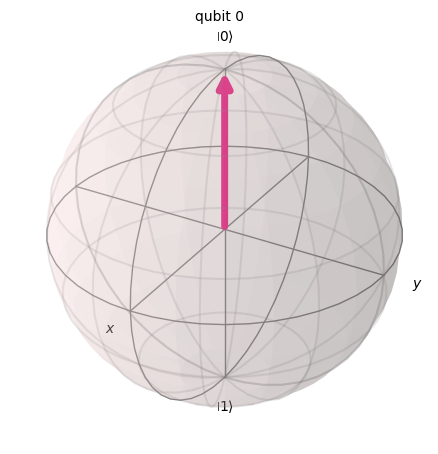

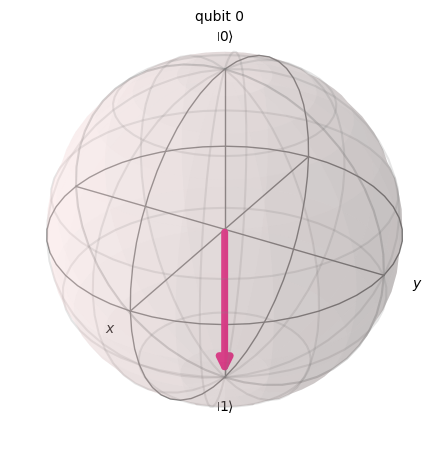

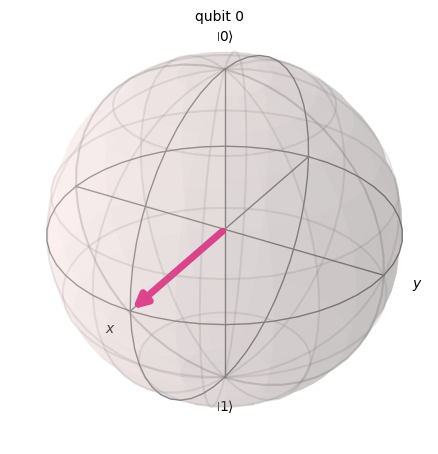

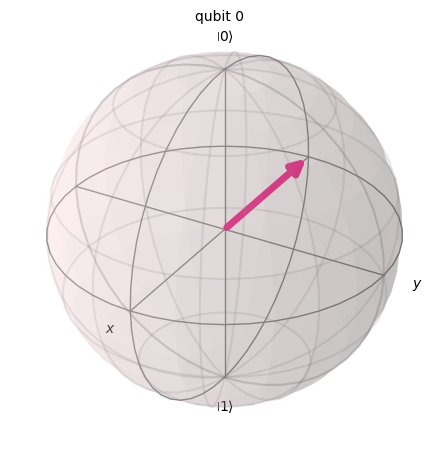

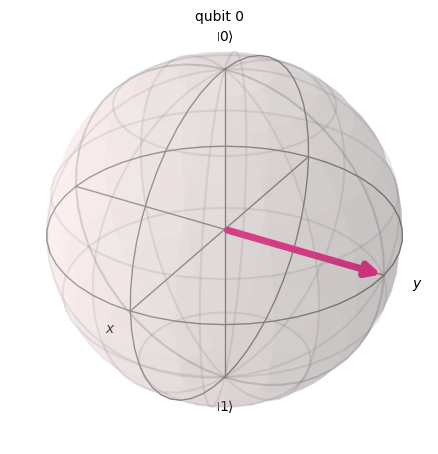

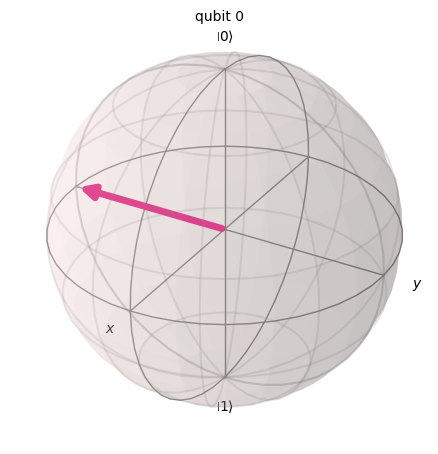

In [4]:
Amps = np.array([[1,0],[0,1],[1,1],[1,1],[1,1],[1,1]],dtype=np.float64)
Phases = np.array([0,0,0,np.pi,np.pi/2,-np.pi/2])
print(Amps[0][0])
for iC, iAmp in enumerate(Amps):
    state = iAmp[0]*np.array([1,0]) + iAmp[1]*np.exp(1j*Phases[iC])*np.array([0,1])
    state = state/np.sqrt(np.sum(np.abs(state)**2))
    display(plot_bloch_multivector(state))

#### Challenge:
Make an aribrary state $|\psi\rangle = \cos\left(\frac{\theta}{2}\right)|0\rangle + \sin\left(\frac{\theta}{2}\right)e^{i\phi}|1\rangle$ where the state is created dynamically and you can switch between any value of $\theta$ and $\phi$. Then vizualize your vector on the Bloch sphere.

Bonus Challenge: Run your code through a for-loop where the tip of the vector traces out a path from the North pole of the Bloch sphere to the South pole in a spiral fashion.

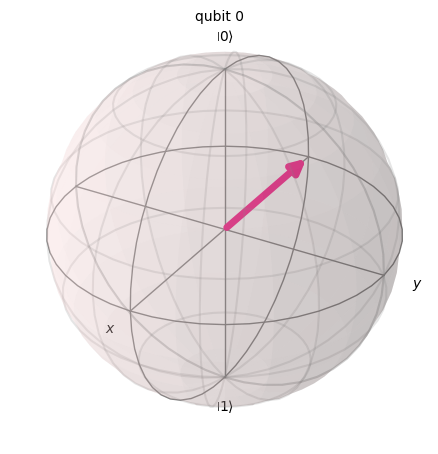

In [7]:
theta = 0.5*np.pi
phi = 1*np.pi
state = np.cos(theta/2)*np.array([1,0]) + np.sin(theta/2)*np.exp(1j*phi)*np.array([0,1])
state = state/np.sqrt(np.sum(np.abs(state)**2))
display(plot_bloch_multivector(state))

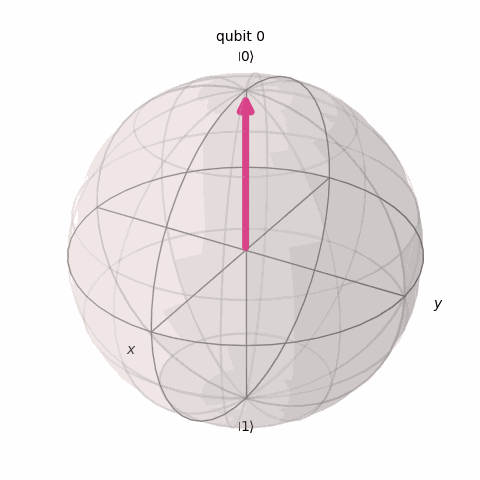

In [18]:
from PIL import Image
from IPython.display import Image as IPImage
import io

thetas = np.linspace(0,2*np.pi, 100)
frames = []
for theta in thetas:
    state = np.cos(theta/2)*np.array([1,0]) + np.sin(theta/2)*np.exp(1j*phi)*np.array([0,1])
    state = state/np.sqrt(np.sum(np.abs(state)**2))
    plot = plot_bloch_multivector(state)

    #display(plot)
    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))





GIF_PATH = 'gif.gif'
frames[0].save(GIF_PATH,
               save_all = True,
               #append_images = frames[1:] + frames[1:-2][::-1],
               append_images = frames[1:],
               duration = 100,
               loop=0)

display(IPImage(data=open(GIF_PATH,'rb').read(), format='png'))



### Quantum circuit visualization

Qiskit allows us to construct a quantum circuit that initializes a qubit into any state. The method QuantumCircuit(n) takes in an integer and prepares and initializes n qubits into the state $|0\rangle$.

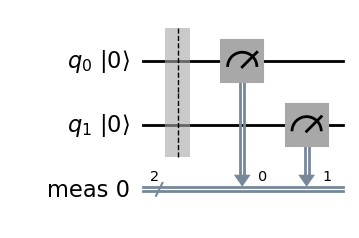

In [9]:
n = 2
QuCirc = QuantumCircuit(n)
QuCirc.measure_all()
QuCirc.draw('mpl', initial_state=True)

### Measuring state
Measurements project a quantum state into the classical computational basis ($(|0\rangle, |1\rangle\ $) for each qubit). Since quantum states can be in superpositions, a single measurement does not reveal the full state; instead, outcomes follow the probability distribution defined by the squared amplitudes of the statevector.

Simulator backend (AerSimulator): allows us to mimic real hardware behavior on a classical computer.

Shots: the number of repetitions of the same circuit. Each shot corresponds to one measurement of the quantum state.

Counts: the aggregated measurement outcomes across all shots.

Example: {'00': 500, '11': 524} means the system collapsed into |00⟩ about 500 times and into |11⟩ about 524 times.

Histogram: visualizes the frequency of each outcome, showing how the underlying quantum state collapses probabilistically when measured.

Measurement results: {'00': 1024}


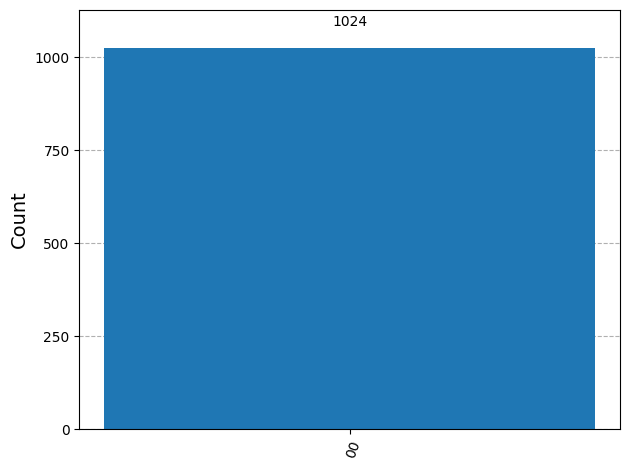

In [19]:
# Create an Aer simulator backend (classical simulator of a quantum computer)
aer_sim = AerSimulator()

# Transpile (compile) the quantum circuit for the simulator backend
# This step converts high-level circuit instructions into a form
# optimized for execution on the chosen backend
tqc = transpile(QuCirc, aer_sim)

# Run the transpiled circuit on the simulator, performing 1024 repeated measurements
# 'shots' = number of times the circuit is executed, to estimate probabilities
result = aer_sim.run(tqc, shots=1024).result()

# Extract the measurement outcomes as a dictionary of bitstrings and counts
# Example: {'00': 500, '11': 524}
counts = result.get_counts()

# Print the raw counts to the console
print("Measurement results:", counts)

# Plot the measurement results as a histogram for visualization
plot_histogram(counts)

#### Challenge:
Initialize an arbitrary circuit using QuCirc.initialize(state, 0) where the state may take any values for $\theta$ and $\phi$ and measure the state as done above.

In [ ]:
from PIL import Image
from IPython.display import Image as IPImage
import io

tqc = transpile(QuCirc, aer_sim)

# Run the transpiled circuit on the simulator, performing 1024 repeated measurements
# 'shots' = number of times the circuit is executed, to estimate probabilities
result = aer_sim.run(tqc, shots=1024).result()

# Extract the measurement outcomes as a dictionary of bitstrings and counts
# Example: {'00': 500, '11': 524}
counts = result.get_counts()

# Print the raw counts to the console
print("Measurement results:", counts)

# Plot the measurement res

n = 2

thetas = np.linspace(0,2*np.pi, 100)
frames = []
for theta in thetas:
    state = np.cos(theta/2)*np.array([1,0]) + np.sin(theta/2)*np.exp(1j*phi)*np.array([0,1])
    state = state/np.sqrt(np.sum(np.abs(state)**2))

    plot = plot_bloch_multivector(state)

    #display(plot)
    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))





GIF_PATH = 'gif.gif'
frames[0].save(GIF_PATH,
               save_all = True,
               #append_images = frames[1:] + frames[1:-2][::-1],
               append_images = frames[1:],
               duration = 100,
               loop=0)

display(IPImage(data=open(GIF_PATH,'rb').read(), format='png'))



In [23]:
qc = QuantumCircuit(n)
qc.initialize(state,qubits=[1])
qc.draw()

q_0: ────────────────────
     ┌──────────────────┐
q_1: ┤ Initialize(-1,0) ├
     └──────────────────┘

## 2. Single Qubit gates and transformations 
### The Pauli Gates (X, Y & Z Gates)
We will now learn about some common quantum gates that will be used to transform our states.

The Pauli X, Y, and Z gates are operations that rotate a single qubit $180^\circ$ ($\pi$ radians) around the corresponding X, Y, or Z axis of the Bloch sphere.

For now we will consider how these gates impact the state $\ket{0}$, the initial value of every qubit in `qiskit`.

#### The X-Gate (Quantum `not`)
The Pauli X-gate corresponds to a rotation around the x-axis. This means it will flip state $\ket{0}$ to state $\ket{1}$ and visa versa making it analogous to a classical `not` operation.

#### The Y gate
The Y-gate does a $\pi$ radian rotation about the Y-axis

#### The Z-Gate
The Z-gate performs a $\pi$ radian rotation around the Z-axis.

Lets apply the different rotation gates to the states below:

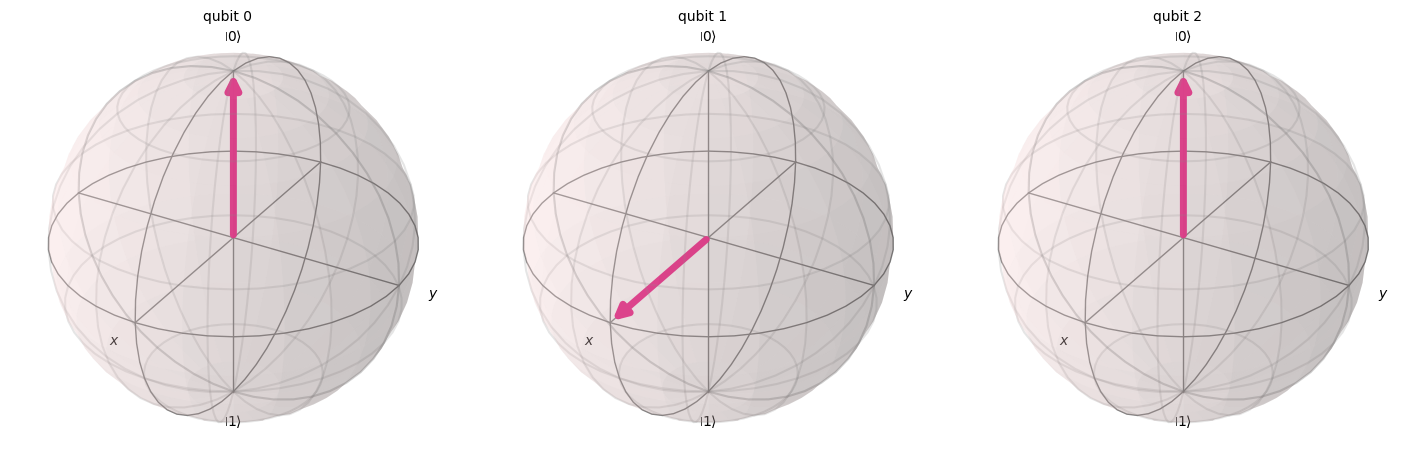

In [34]:
QuCirc = QuantumCircuit(3)

QuCirc.h(1)
QuCirc.h(2)
QuCirc.z(2)
QuCirc.ry(0.5*np.pi,2)
QuCirc.draw('mpl', initial_state=True)

display(plot_bloch_multivector(QuCirc))

#### Challenge:
Why does quibit 2 not rotate?

## The Hadamard (H) Gate - Where the magic happens 

The power of quantum computing is in superposition

And to make superposition we use H-gates!

### Algebraic Description
The operator for this gate is as follows:
$$
H=\frac{1}{\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}
$$

Note that this matrix is not purely diagonal which meas it will translate from the deterministic states $\ket{0}$ and $\ket{1}$ to the probabilistic states $\ket{+}$ and $\ket{-}$

Lets see how that works in code:

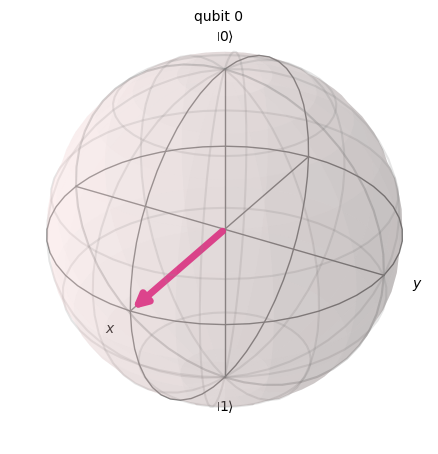

In [ ]:
QuCirc = QuantumCircuit(1)
QuCirc.h(0)
QuCirc.draw('mpl', initial_state=True)

display(plot_bloch_multivector(QuCirc))

#### Challenge:
- Perform 3 operations on an initial state vector such that it follows a closed path on the Bloch sphere. Show the rotation on the bloch sphere. Measure the probabilities as you go as well.
Closed paths are usually associated with geometric phases...do you wanna calculate it?

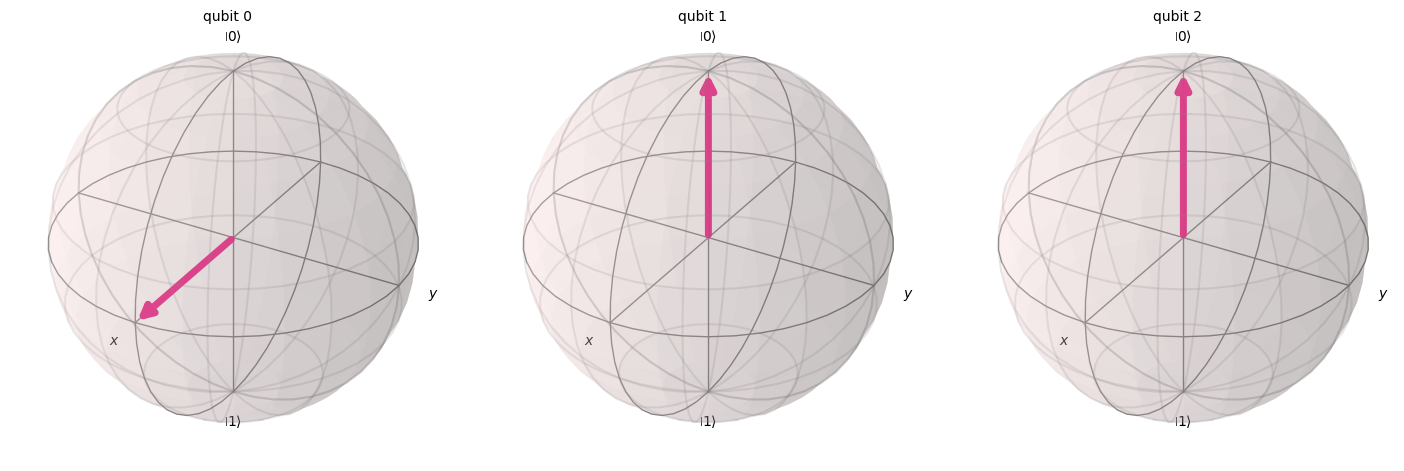

In [32]:
qc = QuantumCircuit(3)


qc.y(0)
qc.h(0)
qc.z(0)

plot_bloch_multivector(qc)

### Arbitrary Rotations on any axis 
We can make arbitrary gates wit even smaller rogations by following the same logic.
For example a $\frac\pi3$ radian ration would use the third primary root of unity

In `qiskit` we can do this using generic `rz` gates.

If we wanted to rotate on the X or Y axis we could use `rx` and `ry` gates as well.

Try some combinations out below, mess about and have fun!

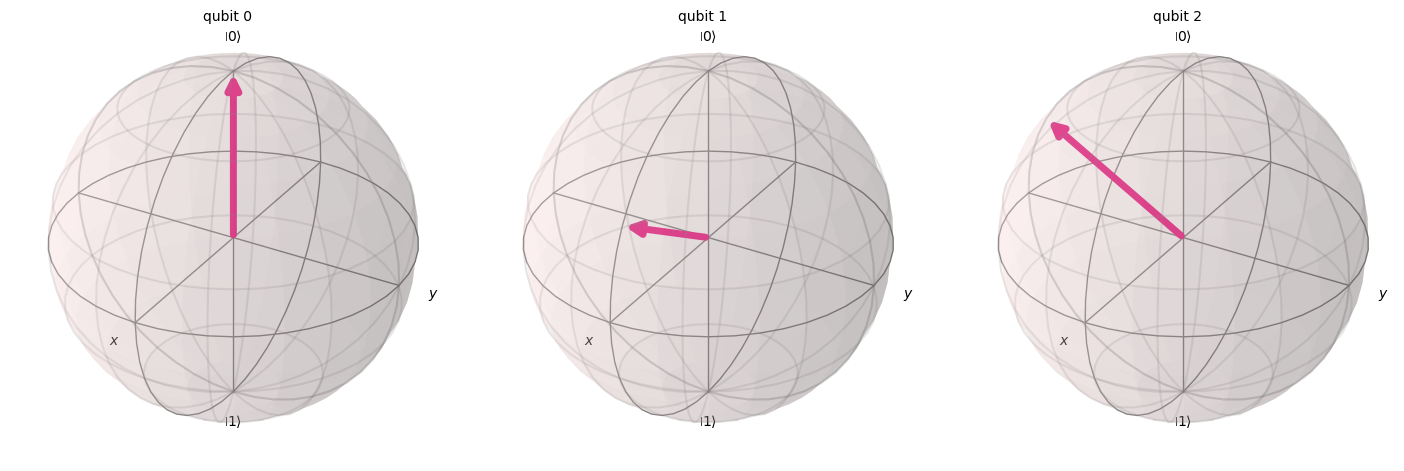

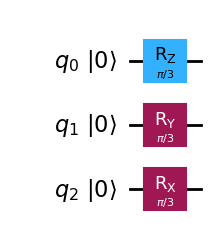

In [ ]:
QuCirc = QuantumCircuit(3)
QuCirc.rz(np.pi/3,0) #You have to specify the control qubit and the target in that order
QuCirc.ry(np.pi/3,1) #You have to specify the control qubit and the target in that order
QuCirc.rx(np.pi/3,2) #You have to specify the control qubit and the target in that order
display(plot_bloch_multivector(QuCirc))
display(QuCirc.draw('mpl', initial_state=True))

#### Challenge:
- You now learnt how to do arbitrary rotations. Try to apply an arbitrary set of rotations that traces out an interesting curve on the bloch sphere. 
Parametrizing curves on a spherical surface... sounds like fun :) 

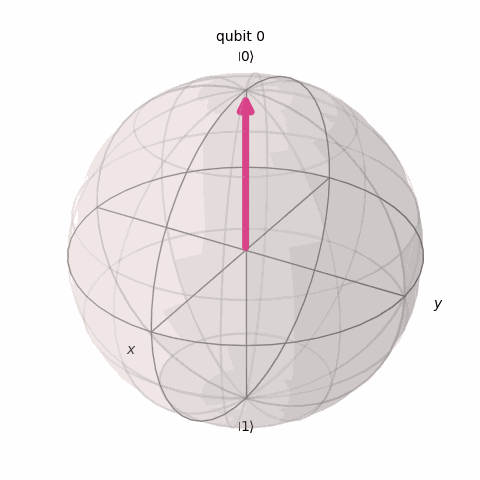

In [ ]:
frames = []

for y_theta in np.linspace(0,0.5*np.pi,100):
    qc = QuantumCircuit(1)
    qc.ry(y_theta,0)
    plot = plot_bloch_multivector(qc)


    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))
for z_theta in np.linspace(0,0.5*np.pi,100):
    qc = QuantumCircuit(1)
    qc.rz(z_theta,0)
    plot = plot_bloch_multivector(qc)


    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))
    
for x_theta in np.linspace(0,0.5*np.pi,100):
    qc = QuantumCircuit(1)
    qc.rx(x_theta,0)
    plot = plot_bloch_multivector(qc)


    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))



GIF_PATH = 'gif.gif'
frames[0].save(GIF_PATH,
               save_all = True,
               #append_images = frames[1:] + frames[1:-2][::-1],
               append_images = frames[1:],
               duration = 100,
               loop=0)
display(IPImage(data=open(GIF_PATH,'rb').read(), format='png'))

## 3. Multi-photon Gates

- A **single qubit** lives in a 2D complex vector space spanned by  
  $\{|0\rangle, |1\rangle\}$.

- To describe **multiple qubits**, we take the **tensor product** of single-qubit spaces:  
  $$
  \mathcal{H}_2 \otimes \mathcal{H}_2 = \mathcal{H}_4
  $$

- The **two-qubit basis** is:  
  $|00\rangle, |01\rangle, |10\rangle, |11\rangle$

- In vector form:
  - $|00\rangle = [1,0,0,0]^T$  
  - $|01\rangle = [0,1,0,0]^T$  
  - $|10\rangle = [0,0,1,0]^T$  
  - $|11\rangle = [0,0,0,1]^T$

- **Scaling:**  
  - 1 qubit → 2D  
  - 2 qubits → 4D  
  - 3 qubits → 8D  
  - $n$ qubits → $2^n$ dimensions

---

- **Single-qubit gates** (X, H, Z, etc.) act on one qubit only.  
- To make qubits interact, we need **multi-qubit gates**.  

### Example: CNOT (Controlled-NOT)

- Control qubit: decides whether to apply NOT (X) to the target.  
- Truth table:  
  - $|00\rangle \to |00\rangle$  
  - $|01\rangle \to |01\rangle$  
  - $|10\rangle \to |11\rangle$  
  - $|11\rangle \to |10\rangle$

- In matrix form (4×4):
$$
\text{CNOT} =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$


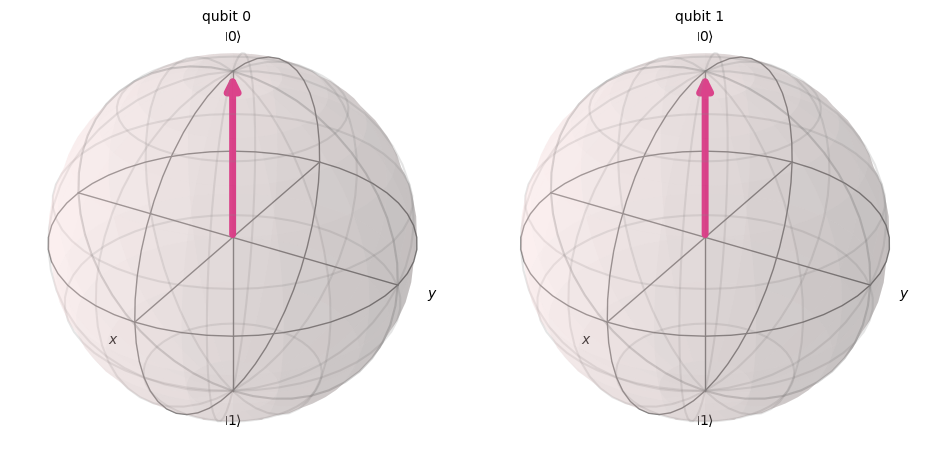

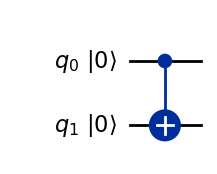

In [221]:
QuCirc = QuantumCircuit(2)
QuCirc.cx(0,1) #You have to specify the control qubit and the target in that order
QuCirc.draw('mpl', initial_state=True)
display(plot_bloch_multivector(QuCirc))
QuCirc.draw('mpl', initial_state=True)


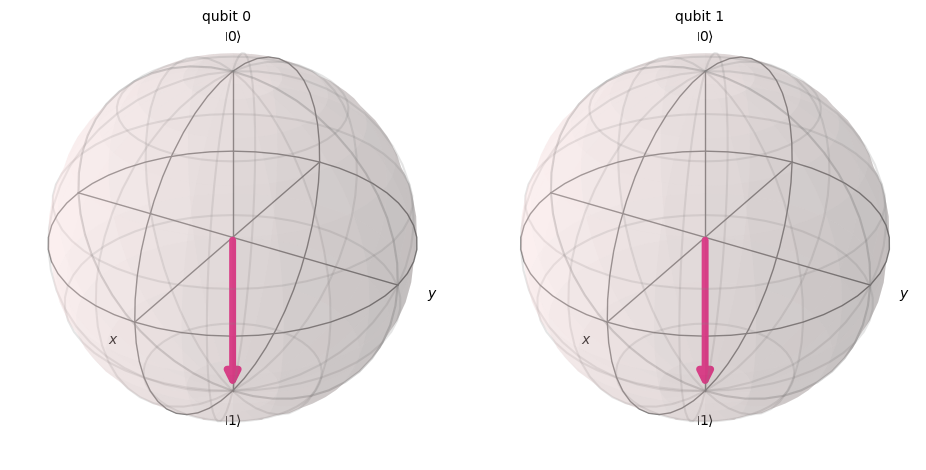

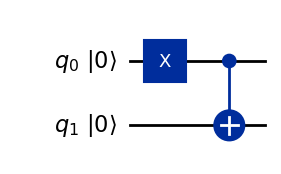

In [219]:
QuCirc = QuantumCircuit(2)
QuCirc.x(0)
QuCirc.cx(0,1) #You have to specify the control qubit and the target in that order
QuCirc.draw('mpl', initial_state=True)
display(plot_bloch_multivector(QuCirc))
QuCirc.draw('mpl', initial_state=True)

## 4. Entanglement 


#### Challenge:
You may not know it yet, but you already have all the tools you need to generate an entangled state. Now go forth and generate one :)
- Generate a simple 2 qubit entangled state of the form: $|00\rangle + |11\rangle$ 
- Generate a simple 2 qubit entangled state of the form: $|01\rangle + |10\rangle$
- Generate a 3 qubit GHZ state entangled in the form: $|000\rangle + |111\rangle$
- Perform measurements on each of the states. Do the measurement outcomes match what you expect?

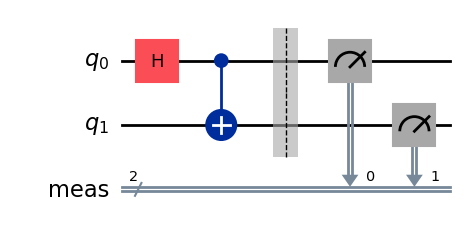

Measurement results: {'11': 484, '00': 540}


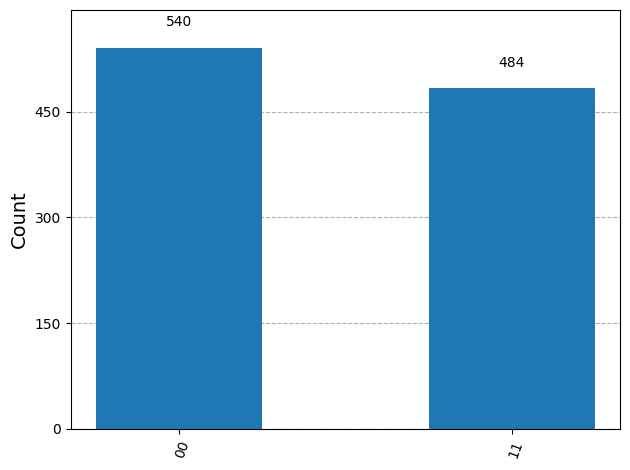

In [44]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
display(qc.draw('mpl'))


aer_sim = AerSimulator()
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=1024).result()
counts = result.get_counts()

# Print the raw counts to the console
print("Measurement results:", counts)

# Plot the measurement results as a histogram for visualization
plot_histogram(counts)

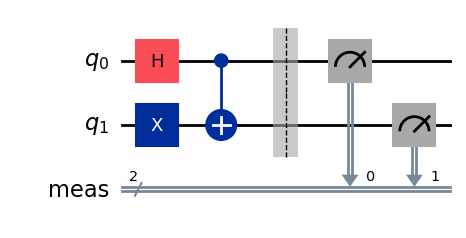

Measurement results: {'01': 535, '10': 489}


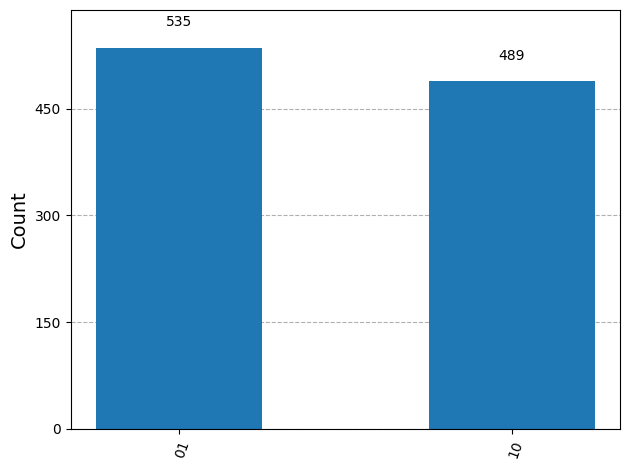

In [43]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cx(0,1)
qc.measure_all()
display(qc.draw('mpl'))


aer_sim = AerSimulator()
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=1024).result()
counts = result.get_counts()

# Print the raw counts to the console
print("Measurement results:", counts)

# Plot the measurement results as a histogram for visualization
plot_histogram(counts)

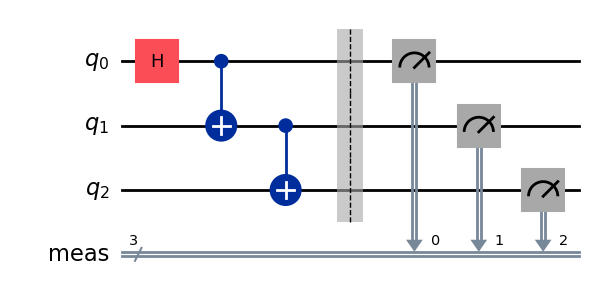

Measurement results: {'111': 501, '000': 523}


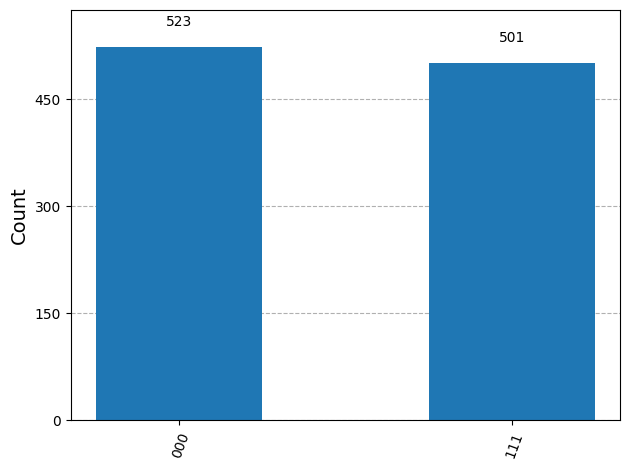

In [40]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.measure_all()
display(qc.draw('mpl'))


aer_sim = AerSimulator()
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=1024).result()
counts = result.get_counts()

# Print the raw counts to the console
print("Measurement results:", counts)

# Plot the measurement results as a histogram for visualization
plot_histogram(counts)

### END ### :)

The design of the circuit is done.


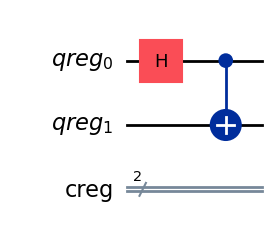

In [26]:





# Tests
# A quantum circuit is composed by quantum and classical bits in Qiskit.
#

# here are the objects that we use to create a quantum circuit in qiskit
#from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# we use a quantum register to keep our quantum bits.
#q =  QuantumRegister(2,"qreg") # in this example we will use a single quantum bit
# the second parameter is optional

# To retrieve an information from a quantum bit, it must be measured. (More details will appear.)
#     The measurement result is stored classically.
#     Therefore, we also use a classical regiser with classical bit(s)
#c = ClassicalRegister(2,"creg") # in this example we will use a single classical bit
# the second parameter is optional

# now we can define our quantum circuit
# it is composed by a quantum and a classical registers
#qc = QuantumCircuit(q,c)

# we apply operators on quantum bits
# operators are called as gates
# we apply NOT operator represented as "x" in qiskit
# operator is a part of the circuit, and we should specify the quantum bit as its parameter
#qc.x(q[0]) # (quantum) bits are enumerated starting from 0
#qc.h(q[0]) # (quantum) bits are enumerated starting from 0
#qc.cx(0,1)

# NOT operator or x-gate is applied to the first qubit of the quantum register

# measurement is defined by associating a quantum bit to a classical bit
#qc.measure(q[0],c[0])
# after the measurement, the observed value of the quantum bit is stored in the classical bit

# we run our codes until now, and then draw our circuit
#print("The design of the circuit is done.")

# we can draw the same circuit by using matplotlib
#qc.draw(output='mpl')

In [123]:

 
#n_qubits = 5
 
#from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
#backend = FakeAlmadenV2()
 
#mat = np.real(random_hermitian(n_qubits, seed=1234))
#circuit = iqp(mat)
#circuit.measure_all()
#qc.measure_all()
 
#pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
#isa_circuit = pm.run(qc)
 
#sampler = Sampler(backend)
#job = sampler.run([isa_circuit],shots=20000)
#result = job.result()
 
# Get results for the first (and only) PUB
#pub_result = result[0]
 
#print(f" > First ten results: {pub_result.data.meas.get_bitstrings()[:10]}")
#counts = pub_result.data.meas.get_counts()

 > First ten results: ['01', '11', '00', '11', '00', '01', '11', '11', '11', '00']


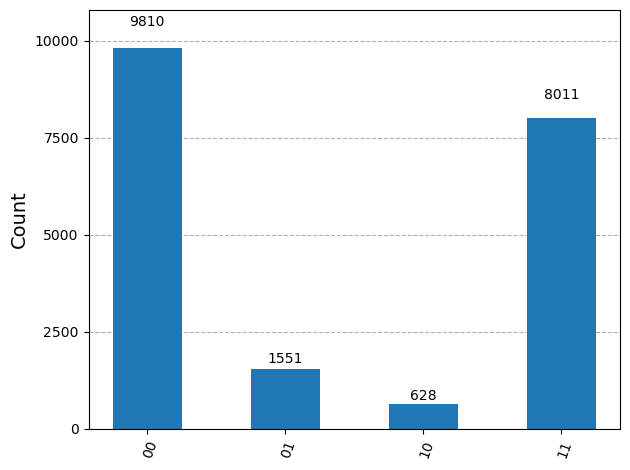

In [119]:
# we can show the result by using histogram as follows
#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

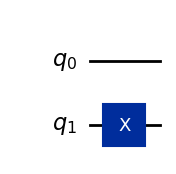

In [148]:
qc = QuantumCircuit(2)
qc.x(1)   
qc.draw('mpl')